# Analysis of Scenario 2: Dynamic reconfiguarion

## Imports

In [1]:
import itertools
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scikit_posthocs as sp


## Parameters

In [2]:
RESULTS_DIR = "../results"
PROTOCOLS = ["http", "grpc"]
GATEWAYS = ["haproxy", "traefik", "tyk", "nginx"]

## Compute latencies
Calculates the time per iteration until the first new service is reached.

In [3]:
def compute_latencies(file_path):
    df = pd.read_csv(file_path)

    # cast string timestamps to int to be able to do calculations
    df["timestamp_ms"] = df["timestamp_ms"].astype(int)

    latencies = []
    for it in df["iteration"].unique():
        it_df = df[df["iteration"] == it]
        switch_ts = it_df[it_df["response"] ==
                          "SWITCH_EVENT"]["timestamp_ms"].iloc[0]

        # filter responses before switch event
        before_responses = it_df[it_df["timestamp_ms"]
                                 < switch_ts]["response"].tolist()

        # determine current target before switch
        current_target = "A" if "A" in before_responses[-1] else "B"
        new_target = "B" if current_target == "A" else "A"

        # find first successful response from new target after switch
        first_new = it_df[
            (it_df["timestamp_ms"] > switch_ts)
            & (it_df["response"].str.contains(new_target))
            & (it_df["success"] == True)
        ]["timestamp_ms"].iloc[0]

        # calculate and append latency
        latencies.append(first_new - switch_ts)
    return np.array(latencies)

# Fastest and slowest switchover across all gateways for HTTP

In [4]:
fastest = {}
slowest = {}

for gw in GATEWAYS:
    file = os.path.join(RESULTS_DIR, f"http_dynamic_switch_{gw}.csv")
    lats = compute_latencies(file)
    fastest[gw] = np.min(lats)
    slowest[gw] = np.max(lats)

fastest_gw = min(fastest, key=fastest.get)
slowest_gw = max(slowest, key=slowest.get)

print(f"Fastest switchover (HTTP): {fastest_gw.upper()} with {fastest[fastest_gw]} ms")
print(f"Slowest switchover (HTTP): {slowest_gw.upper()} with {slowest[slowest_gw]} ms")

Fastest switchover (HTTP): TRAEFIK with 55 ms
Slowest switchover (HTTP): TYK with 1046 ms


# Fastest and slowest switchover across all gateways for gRPC

In [5]:
fastest = {}
slowest = {}

for gw in GATEWAYS:
    file = os.path.join(RESULTS_DIR, f"grpc_dynamic_switch_{gw}.csv")
    lats = compute_latencies(file)
    fastest[gw] = np.min(lats)
    slowest[gw] = np.max(lats)

fastest_gw = min(fastest, key=fastest.get)
slowest_gw = max(slowest, key=slowest.get)

print(f"Fastest switchover (gRPC): {fastest_gw.upper()} with {fastest[fastest_gw]} ms")
print(f"Slowest switchover (gRPC): {slowest_gw.upper()} with {slowest[slowest_gw]} ms")

Fastest switchover (gRPC): TRAEFIK with 54 ms
Slowest switchover (gRPC): NGINX with 1416 ms


# Analysis of individual gateways
Dynamic reconfiguration latencies over 100 iterations in histograms

In [6]:
def plot_latency_histogram(latencies, title, bins=np.linspace(0, 2000, 40)):
    plt.figure(figsize=(8, 4))
    plt.hist(latencies, bins=bins)
    plt.title(title)
    plt.xlabel("Switch latency (ms)")
    plt.ylabel("Frequency across 100 iterations")
    plt.grid(axis='y', alpha=0.4)
    plt.show()


def analyze(gateway):
    print(f"Analysis for {gateway.upper()}\n")

    results = {}
    for proto in PROTOCOLS:
        file = os.path.join(
            RESULTS_DIR, f"{proto}_dynamic_switch_{gateway}.csv")
        lats = compute_latencies(file)
        if len(lats) > 0:
            results[proto] = lats
            print(proto)
            print(f"{len(lats)} iterations")
            print(f"mean: {np.mean(lats):.0f} ms")
            print(f"std: {np.std(lats):.0f} ms ")
            print(f"min: {np.min(lats)}")
            print(f"max: {np.max(lats)}\n")

    # separate plots for each protocol
    for proto, lats in results.items():
        title = f"{gateway.upper()} - {proto.upper()} switch latencies"
        plot_latency_histogram(lats, title)

## HAProxy

Analysis for HAPROXY

http
100 iterations
mean: 180 ms
std: 9 ms 
min: 157
max: 202

grpc
100 iterations
mean: 320 ms
std: 278 ms 
min: 216
max: 1406



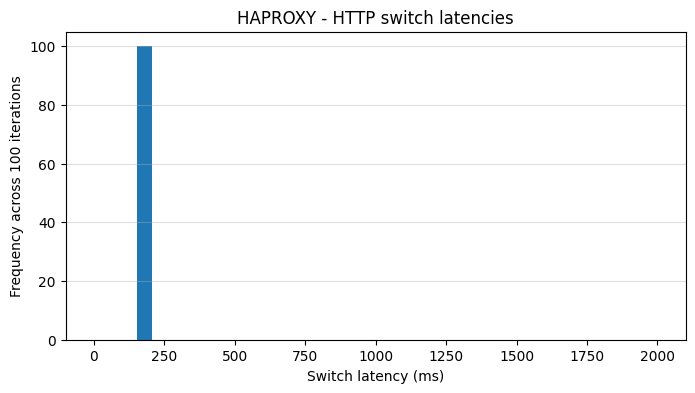

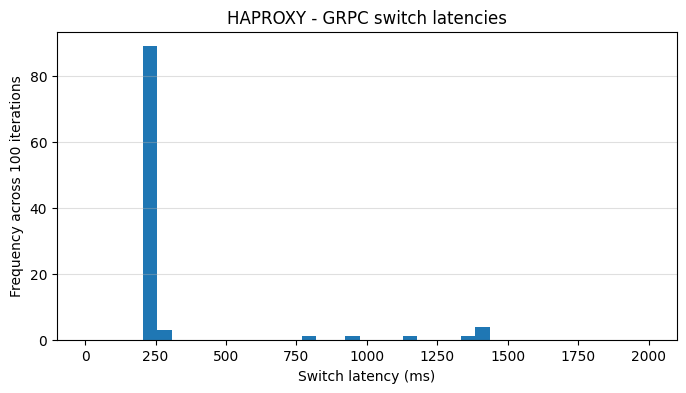

In [7]:
analyze("haproxy")

## NGINX

Analysis for NGINX

http
100 iterations
mean: 219 ms
std: 30 ms 
min: 151
max: 257

grpc
100 iterations
mean: 335 ms
std: 300 ms 
min: 208
max: 1416



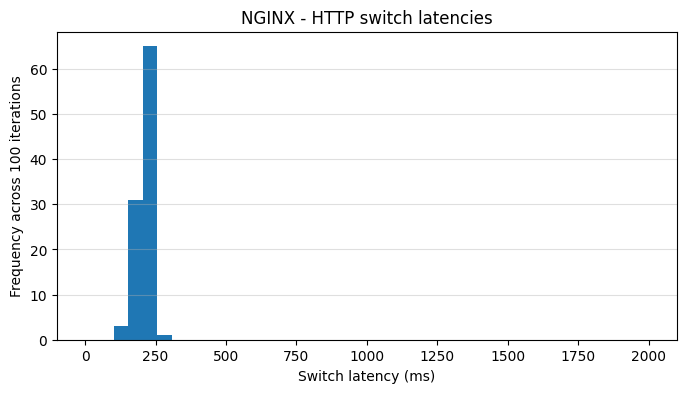

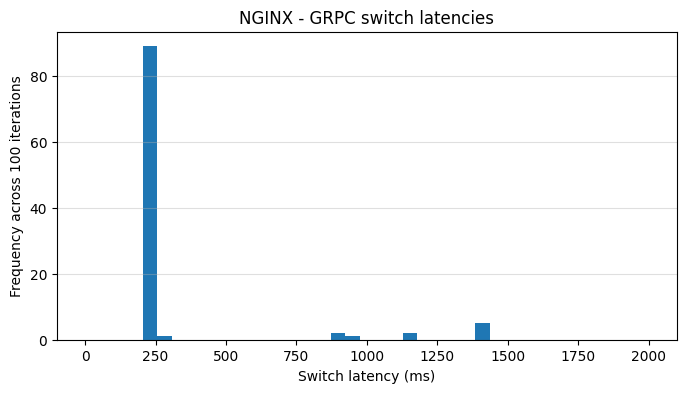

In [8]:
analyze("nginx")

## Traefik

Analysis for TRAEFIK

http
100 iterations
mean: 203 ms
std: 106 ms 
min: 55
max: 552

grpc
100 iterations
mean: 210 ms
std: 105 ms 
min: 54
max: 707



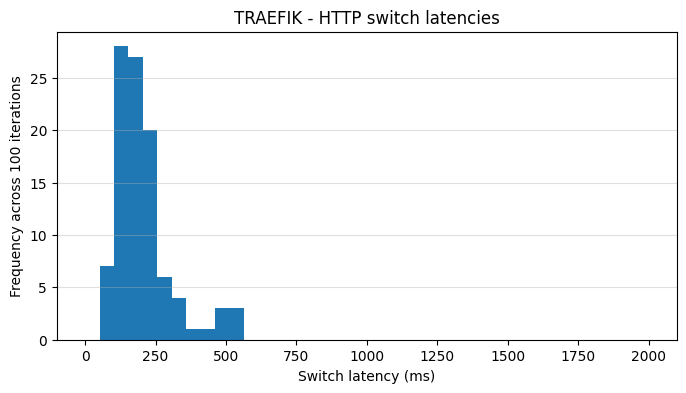

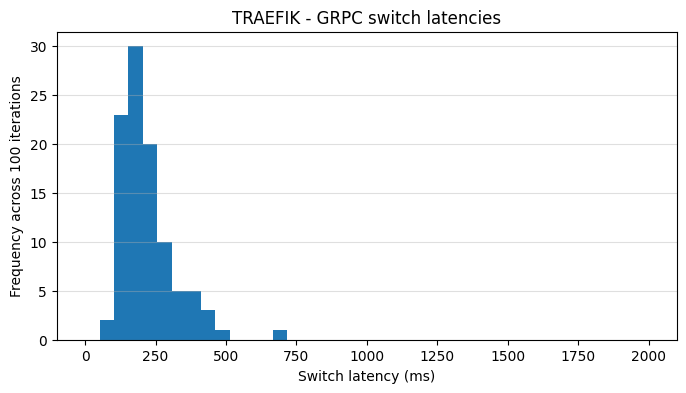

In [9]:
analyze("traefik")

# Tyk

Analysis for TYK

http
100 iterations
mean: 573 ms
std: 296 ms 
min: 58
max: 1046

grpc
100 iterations
mean: 534 ms
std: 294 ms 
min: 60
max: 1039



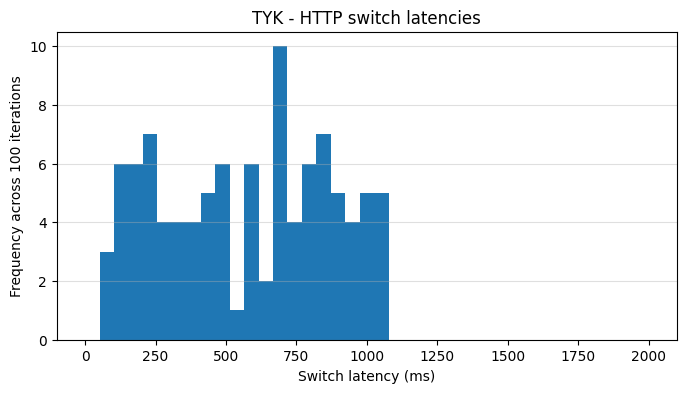

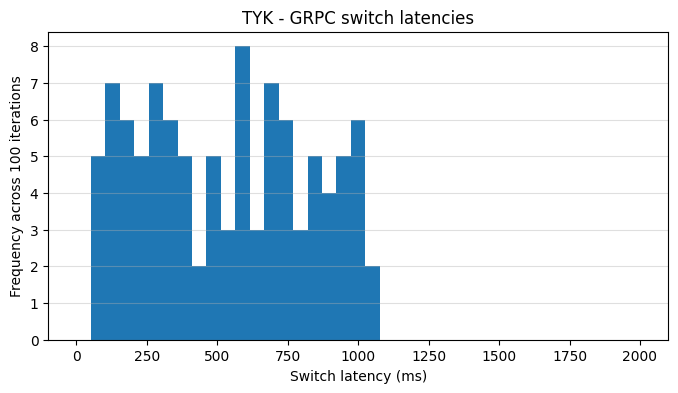

In [10]:
analyze("tyk")

# Dynamic reconfiguration switch latency across gateways

In [11]:
# Unified gateway color map
GATEWAY_COLORS = {
    "caddy": "red",
    "haproxy": "green",
    "traefik": "blue",
    "tyk": "orange",
    "nginx": "purple",
}

http  haproxy  100 iterations   Ø 180.2 ms ± 9.1 ms
http  traefik  100 iterations   Ø 202.9 ms ± 106.5 ms
http  tyk      100 iterations   Ø 572.8 ms ± 296.2 ms
http  nginx    100 iterations   Ø 218.8 ms ± 29.7 ms
grpc  haproxy  100 iterations   Ø 320.2 ms ± 277.5 ms
grpc  traefik  100 iterations   Ø 210.5 ms ± 104.7 ms
grpc  tyk      100 iterations   Ø 533.6 ms ± 293.7 ms
grpc  nginx    100 iterations   Ø 335.0 ms ± 299.8 ms

Boxplot for http:


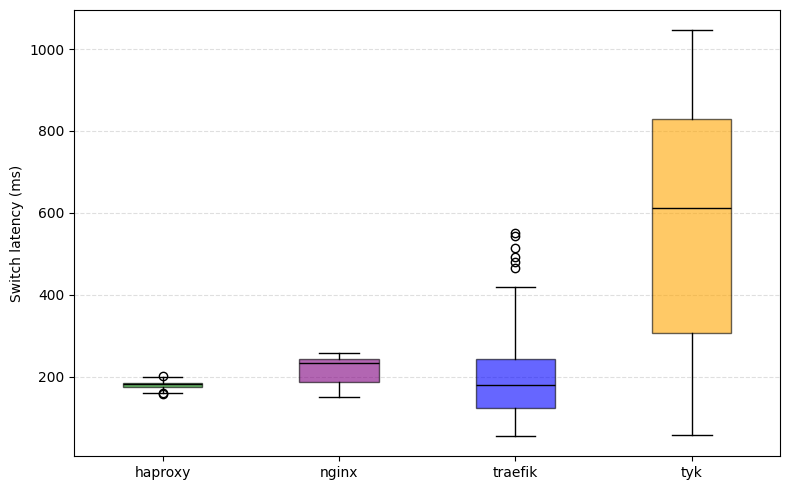


Boxplot for grpc:


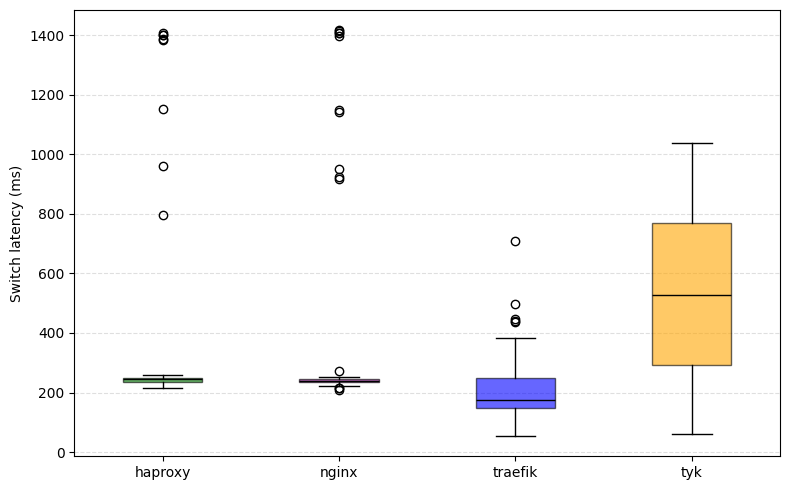

In [12]:
def gather_data_for_boxplot():
    data = {proto: {} for proto in PROTOCOLS}

    for proto in PROTOCOLS:
        for gw in GATEWAYS:
            file = os.path.join(
                RESULTS_DIR, f"{proto}_dynamic_switch_{gw}.csv")
            lats = compute_latencies(file)
            data[proto][gw] = lats
            
            print(f"{proto:<5} {gw:<8} {len(lats)} iterations   "
                    f"Ø {np.mean(lats):.1f} ms ± {np.std(lats):.1f} ms")
    return data


def plot_boxplots(data):
    for proto, gw_data in data.items():
        print(f"\nBoxplot for {proto}:")
        labels = sorted(gw_data.keys())
        values = [gw_data[gw] for gw in labels]

        fig, ax = plt.subplots(figsize=(8, 5))

        bp = ax.boxplot(
            values,
            tick_labels=[lbl for lbl in labels],
            patch_artist=True,
            medianprops=dict(color="black"),
        )

        for patch, gw in zip(bp["boxes"], labels):
            patch.set_facecolor(GATEWAY_COLORS.get(gw, "lightgray"))
            patch.set_alpha(0.6)

        # ax.set_title(f"{proto.replace('_', ' ').title()} — Switch Latency Comparison")
        ax.set_ylabel("Switch latency (ms)")
        ax.grid(True, axis="y", linestyle="--", alpha=0.4)

        plt.tight_layout()
        plt.savefig(f"findings-scenario-2-{proto}.png", dpi=300)
        plt.show()


def analyze_boxplot():
    data = gather_data_for_boxplot()
    plot_boxplots(data)

analyze_boxplot()

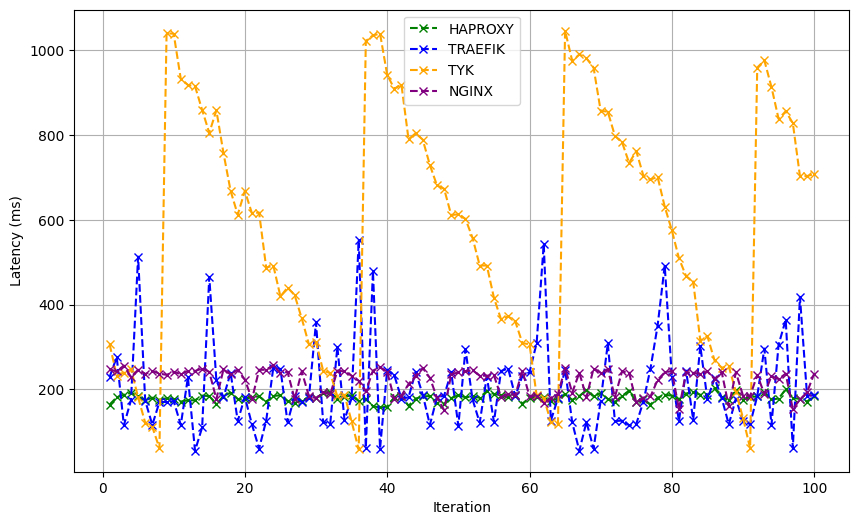

In [13]:
plt.figure(figsize=(10, 6))
for gw in GATEWAYS:
    file_http = os.path.join(
        RESULTS_DIR, f"http_dynamic_switch_{gw}.csv")
    lats_http = compute_latencies(file_http)

    plt.plot(
        range(1, len(lats_http) + 1),
        lats_http,
        "x--",
        label=gw.upper(),
        color=GATEWAY_COLORS.get(gw, "lightgray"),
    )
plt.legend()
# plt.title("HTTP Dynamic Switch Latencies")
plt.xlabel("Iteration")
plt.ylabel("Latency (ms)")
plt.grid(True)
plt.savefig(f"findings-scenario-2-per-iteration-http.png", dpi=300)
plt.show()

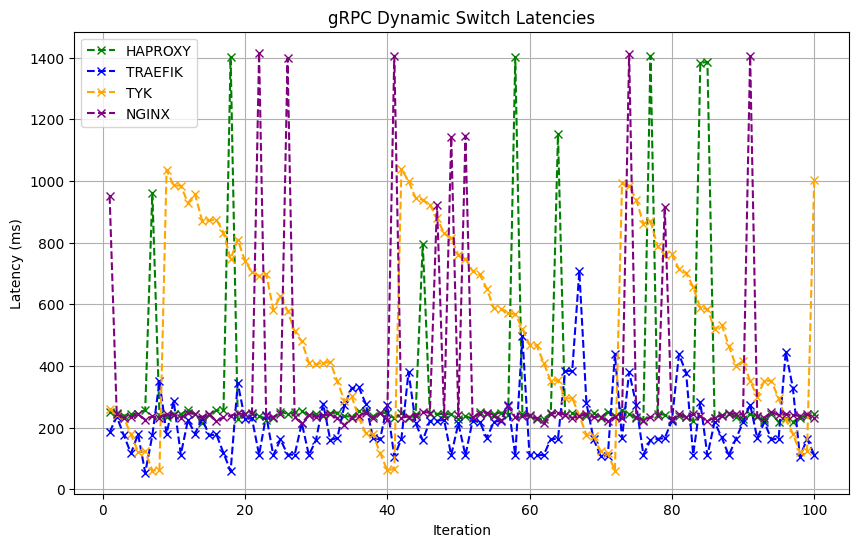

In [14]:
plt.figure(figsize=(10, 6))
for gw in GATEWAYS:
    file_http = os.path.join(
        RESULTS_DIR, f"grpc_dynamic_switch_{gw}.csv")
    lats_http = compute_latencies(file_http)

    plt.plot(
        range(1, len(lats_http) + 1),
        lats_http,
        "x--",
        label=gw.upper(),
        color=GATEWAY_COLORS.get(gw, "lightgray"),
    )
plt.legend()
plt.title("gRPC Dynamic Switch Latencies")
plt.xlabel("Iteration")
plt.ylabel("Latency (ms)")
plt.grid(True)
plt.show()

# Summarized data

In [15]:
def summarize_results():
    summary = []

    for gw in GATEWAYS:
        for proto in PROTOCOLS:
            file = os.path.join(RESULTS_DIR, f"{proto}_dynamic_switch_{gw}.csv")
            lats = compute_latencies(file)
            if len(lats) > 0:
                summary.append({
                    "Gateway": gw.upper(),
                    "Protocol": proto.replace('_', ' ').title(),
                    "Mean Latency (ms)": f"{np.mean(lats):.1f}",
                    "Std Dev (ms)": f"{np.std(lats):.1f}",
                    "Median Latency (ms)": f"{np.median(lats):.1f}",
                    "Min Latency (ms)": f"{np.min(lats)}",
                    "Max Latency (ms)": f"{np.max(lats)}",
                    "Iterations": len(lats)
                })

    df_summary = pd.DataFrame(summary)
    display(df_summary)

    # Export to CSV for LaTeX table
    df_summary.round(2).to_csv("../results/summary_all_gateways.csv", index=False)
summarize_results()

,Gateway,Protocol,Mean Latency (ms),Std Dev (ms),Median Latency (ms),Min Latency (ms),Max Latency (ms),Iterations
0,HAPROXY,Http,180.2,9.1,181.0,157,202,100
1,HAPROXY,Grpc,320.2,277.5,244.0,216,1406,100
2,TRAEFIK,Http,202.9,106.5,180.0,55,552,100
3,TRAEFIK,Grpc,210.5,104.7,176.5,54,707,100
4,TYK,Http,572.8,296.2,612.5,58,1046,100
5,TYK,Grpc,533.6,293.7,527.5,60,1039,100
6,NGINX,Http,218.8,29.7,234.5,151,257,100
7,NGINX,Grpc,335.0,299.8,239.0,208,1416,100


# Significance testing

In [16]:
def load_all_latencies():
    data = {proto: {} for proto in PROTOCOLS}
    for proto in PROTOCOLS:
        for gw in GATEWAYS:
            file = os.path.join(
                RESULTS_DIR, f"{proto}_dynamic_switch_{gw}.csv")
            lats = compute_latencies(file)
            data[proto][gw] = lats
    return data

## Student's t-test

In [17]:
data = load_all_latencies()

for proto in PROTOCOLS:
    print(f"Student's t-test analysis for {proto.upper()}")

    gw_data = data[proto]
    gateways = sorted(gw_data.keys())

    df_long = pd.DataFrame(
        [(gw, value) for gw in gateways for value in gw_data[gw]],
        columns=["gateway", "latency"]
    )

    # perform pairwise t-tests
    ttest_results = sp.posthoc_ttest(
        df_long,
        val_col="latency",
        group_col="gateway",
        equal_var=False,
        sort=True
    )

    print("T-test p-values matrix")
    
    print("actual values:")
    display(ttest_results)
    print("rounded values:")
    display(ttest_results.round(3))
    print("significant differences matrix (p < 0.05):")
    display(ttest_results < 0.05)

    # check for significant differences
    print("Significant differences (p < 0.05):")
    for a, b in itertools.combinations(gateways, 2):
        p = ttest_results.loc[a, b]
        if p < 0.05:
            print(f"{a} vs {b}: p={p:.20f}")
    print("\n\n")

Student's t-test analysis for HTTP
T-test p-values matrix
actual values:


,haproxy,nginx,traefik,tyk
haproxy,1.000000e+00,5.353926e-23,3.644925e-02,1.576348e-23
nginx,5.353926e-23,1.000000e+00,1.558861e-01,8.822662e-21
traefik,3.644925e-02,1.558861e-01,1.000000e+00,9.539454e-22
tyk,1.576348e-23,8.822662e-21,9.539454e-22,1.000000e+00


rounded values:


,haproxy,nginx,traefik,tyk
haproxy,1.000,0.000,0.036,0.0
nginx,0.000,1.000,0.156,0.0
traefik,0.036,0.156,1.000,0.0
tyk,0.000,0.000,0.000,1.0


significant differences matrix (p < 0.05):


,haproxy,nginx,traefik,tyk
haproxy,False,True,True,True
nginx,True,False,False,True
traefik,True,False,False,True
tyk,True,True,True,False


Significant differences (p < 0.05):
haproxy vs nginx: p=0.00000000000000000000
haproxy vs traefik: p=0.03644925357620987239
haproxy vs tyk: p=0.00000000000000000000
nginx vs tyk: p=0.00000000000000000001
traefik vs tyk: p=0.00000000000000000000



Student's t-test analysis for GRPC
T-test p-values matrix
actual values:


,haproxy,nginx,traefik,tyk
haproxy,1.000000e+00,0.718165,3.443761e-04,3.812079e-07
nginx,7.181646e-01,1.000000,1.565649e-04,4.695796e-06
traefik,3.443761e-04,0.000157,1.000000e+00,2.271380e-18
tyk,3.812079e-07,0.000005,2.271380e-18,1.000000e+00


rounded values:


,haproxy,nginx,traefik,tyk
haproxy,1.000,0.718,0.0,0.0
nginx,0.718,1.000,0.0,0.0
traefik,0.000,0.000,1.0,0.0
tyk,0.000,0.000,0.0,1.0


significant differences matrix (p < 0.05):


,haproxy,nginx,traefik,tyk
haproxy,False,False,True,True
nginx,False,False,True,True
traefik,True,True,False,True
tyk,True,True,True,False


Significant differences (p < 0.05):
haproxy vs traefik: p=0.00034437611812409820
haproxy vs tyk: p=0.00000038120786903743
nginx vs traefik: p=0.00015656486021741457
nginx vs tyk: p=0.00000469579630483493
traefik vs tyk: p=0.00000000000000000227



